In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import sem
import os
import scipy
from scipy.integrate import odeint
import scipy.integrate as integ

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#053061', '#f4a582']

def figure_size_setting(WIDTH):
    #WIDTH = 700.0  # the number latex spits out
    FACTOR = 0.8  # the fraction of the width you'd like the figure to occupy
    fig_width_pt  = WIDTH * FACTOR
    inches_per_pt = 1.0 / 72.27
    golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
    fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
    fig_height_in = fig_width_in * golden_ratio   # figure height in inches
    fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
    return fig_dims


## Compile fitted data as a figure

In [2]:
########### import the pickled file
import pickle
pickle_in = open("fitted_data.pickle","rb")
[df_amino_acid_ID, B_pred_all, B_exp_all, B_pred_glv_all, B_exp_glv_all, production_ratio_array, stoichiometry_array, df_14member_replicate1, df_14member_replicate2, B_t, B_t_glv] = pickle.load(pickle_in)


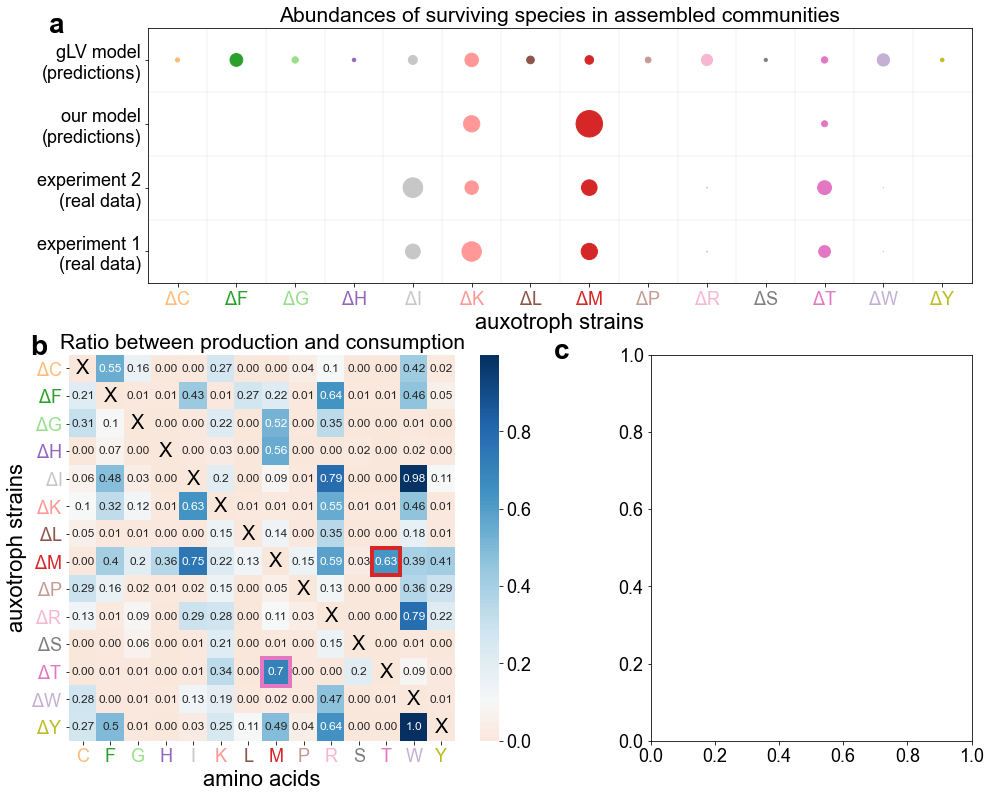

In [3]:
import matplotlib.gridspec as gridspec
from scipy import stats
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.default'] = 'regular'
SMALL_SIZE = 12
MEDIUM_SIZE = 18
plt.rc('axes', labelsize=MEDIUM_SIZE+4)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
from matplotlib import cm
cmap = cm.get_cmap('tab20') # Colour map (there are many others)
plt.rc('text.latex', preamble=r'\usepackage[cm]{sfmath}')

# Create the figure
plt.figure(figsize=(14, 11))
gs = gridspec.GridSpec(11, 11)  # Define a grid of 2 rows x 2 columns
ax = plt.subplot(gs[5:, :6])
production_stoichiometry_ratio = production_ratio_array / stoichiometry_array
production_stoichiometry_ratio[production_stoichiometry_ratio<=0] = 1
sort_order = np.argsort(np.min(production_stoichiometry_ratio,1))[::-1]
# Create a mask for the diagonal
mask = np.eye(production_ratio_array.shape[0], dtype=bool)
#annot = np.round(annot, 2)
annot = np.round((production_ratio_array / stoichiometry_array),2)
annot = annot.astype('str')
annot[annot=='0.0']='0.00'
np.fill_diagonal(annot, '')
#g = sns.heatmap((production_ratio_array / stoichiometry_array), mask=mask, annot=True, fmt='.2f', ax=ax, cmap = "RdBu", center=0.1)
#g = sns.heatmap(np.log10((production_ratio_array / stoichiometry_array) + 1e-5), annot=True, fmt='.1f', ax=ax, cmap = "RdBu")
g = sns.heatmap((production_ratio_array / stoichiometry_array), annot=annot, fmt='', ax=ax, cmap = "RdBu", center=0.1)
# Add crosses on the diagonal
for i in range(production_ratio_array.shape[0]):
    ax.text(i+0.5, i+0.5, 'X', fontsize=20, ha='center', va='center', color='black')
ax.set_aspect("equal")
#### highlight cells
from matplotlib.patches import Rectangle
w, h = 1, 1
index_color_reordered = np.array([3,4,5,8,15,7,10,6,11,13,14,12,9,16]).astype(int)
color_selected = np.array(cmap.colors)[index_color_reordered]
x = 7; y = 11; ax.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor=color_selected[y], lw=4, clip_on=False))
x = 11; y = 7; ax.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor=color_selected[y], lw=4, clip_on=False))
ax.set_xlabel('amino acids')
ax.set_ylabel('auxotroph strains')
ax.set_xticks(np.array(range(production_ratio_array.shape[1]))+0.5)
ax.set_xticklabels(list(map(lambda x: x, list(df_amino_acid_ID.index))))
ax.set_yticks(np.array(range(production_ratio_array.shape[0]))+0.5)
ax.set_yticklabels(df_amino_acid_ID.index)

for ticklabel, tickcolor in zip(g.get_yticklabels(), color_selected):
    ticklabel.set_color(tickcolor)
for ticklabel, tickcolor in zip(g.get_xticklabels(), color_selected):
    ticklabel.set_color(tickcolor)
ax.set_yticklabels(list(map(lambda x: r"$\Delta$"+x, list(df_amino_acid_ID.index))))
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
ax.set_title('Ratio between production and consumption', fontsize=21)
ax.text(-0.1, 1.0, "b", transform=ax.transAxes, fontsize=28, fontweight='bold')

#ax = axes[1]
ax = plt.subplot(gs[0:4, 1:])
df_plot = pd.DataFrame.from_dict({'experiment 1\n(real data)': df_14member_replicate1.values[:,-1],
                                  'experiment 2\n(real data)': df_14member_replicate2.values[:,-1],
                                  'our model\n(predictions)': (B_t/B_t.sum(1)[:,np.newaxis])[-1,:],
                                  'gLV model\n(predictions)': (B_t_glv/B_t_glv.sum(1)[:,np.newaxis])[-1,:],})
# plot data in stack manner of a table using a scatter plot
c = color_selected.copy()
s = np.array(df_plot.iloc[:,0]).astype(float) * 1000
ax.scatter(list(range(14)), np.zeros(14), c=c, s=s)
s = np.array(df_plot.iloc[:,1]).astype(float) * 1000
ax.scatter(list(range(14)), np.zeros(14)+1, c=c, s=s)
s = np.array(df_plot.iloc[:,2]).astype(float) * 1000
ax.scatter(list(range(14)), np.zeros(14)+2, c=c, s=s)
s = np.array(df_plot.iloc[:,3]).astype(float) * 1000
ax.scatter(list(range(14)), np.zeros(14)+3, c=c, s=s)
#### add custom grid
for y_separator in np.arange(0.5, 3.5, 1.0):
    ax.axhline(y_separator, linestyle='-', lw = 0.1, color='grey') # horizontal lines
ax.set_ylim([-0.5,3.5])
for x_separator in np.arange(0.5, 13.5, 1.0):
    ax.axvline(x_separator, linestyle='-', lw = 0.1, color='grey') # vertical lines
ax.set_xlim([-0.5,13.5])
ax.set_xticks(np.array(range(production_ratio_array.shape[0])))
ax.set_xticklabels(list(map(lambda x: r"$\Delta$"+x, list(df_amino_acid_ID.index))))
for ticklabel, tickcolor in zip(ax.get_xticklabels(), color_selected):
    ticklabel.set_color(tickcolor)
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(df_plot.columns)
ax.set_xlabel('auxotroph strains')
ax.set_title('Abundances of surviving species in assembled communities', fontsize=21)
ax.text(-0.12, 0.98, "a", transform=ax.transAxes, fontsize=28, fontweight='bold')

ax = plt.subplot(gs[5:, 7:])
ax.text(-0.3, 0.99, "c", transform=ax.transAxes, fontsize=28, fontweight='bold')

#plt.tight_layout(h_pad=1.0, w_pad=2.0)
plt.subplots_adjust(left=.07, bottom=.07, right=.97, top=.97, hspace=0.1)
#plt.savefig('./figures/Fig_4.pdf', dpi=300)


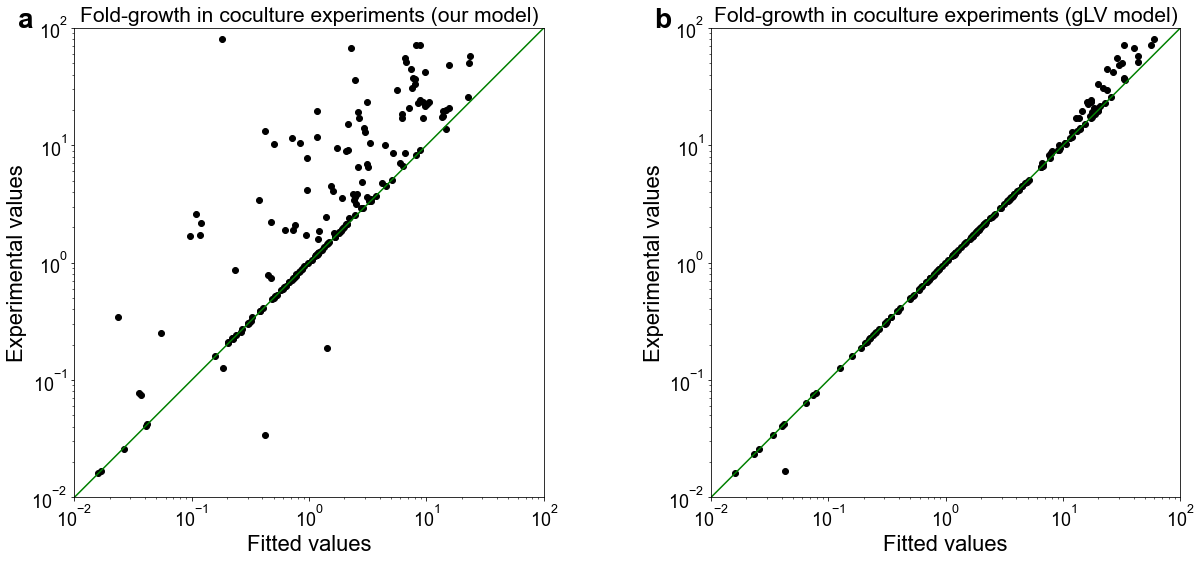

In [4]:
from scipy import stats
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.default'] = 'regular'
SMALL_SIZE = 12
MEDIUM_SIZE = 18
plt.rc('axes', labelsize=MEDIUM_SIZE+4)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
from matplotlib import cm
cmap = cm.get_cmap('tab20') # Colour map (there are many others)
plt.rc('text.latex', preamble=r'\usepackage[cm]{sfmath}')

fig_dims = figure_size_setting(1600)
fig_dims = [fig_dims[0], fig_dims[0]*0.45]
fig, axes = plt.subplots(1, 2, figsize=fig_dims)

ax = axes[0]
ax.plot(np.array(B_pred_all).flatten(), np.array(B_exp_all).flatten(), 'ko')
ax.plot([0,100], [0,100], 'g-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Experimental values')
ax.set_xlabel('Fitted values')
ax.set_title('Fold-growth in coculture experiments (our model)', fontsize=21)
ax.set_aspect('equal')
ax.set_xlim([1e-2, 1e2]); ax.set_ylim([1e-2, 1e2])
ax.text(-0.12, 1.0, "a", transform=ax.transAxes, fontsize=28, fontweight='bold')

ax = axes[1]
#ax.plot(np.array(B_exp_all).flatten(), np.array(B_pred_all).flatten(), 'ko')
ax.plot(np.array(B_pred_glv_all).flatten(), np.array(B_exp_glv_all).flatten(), 'ko')
ax.plot([0,100], [0,100], 'g-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Experimental values')
ax.set_xlabel('Fitted values')
ax.set_title('Fold-growth in coculture experiments (gLV model)', fontsize=21)
ax.set_aspect('equal')
ax.set_xlim([1e-2, 1e2]); ax.set_ylim([1e-2, 1e2])
ax.text(-0.12, 1.0, "b", transform=ax.transAxes, fontsize=28, fontweight='bold')

fig.tight_layout(h_pad=1.0, w_pad=2.0)
#fig.subplots_adjust(left=.1, bottom=.12, right=.97, top=.97, hspace=0.1)
#fig.savefig('./figures/SI figures/SI_Fig_4.pdf', dpi=300)


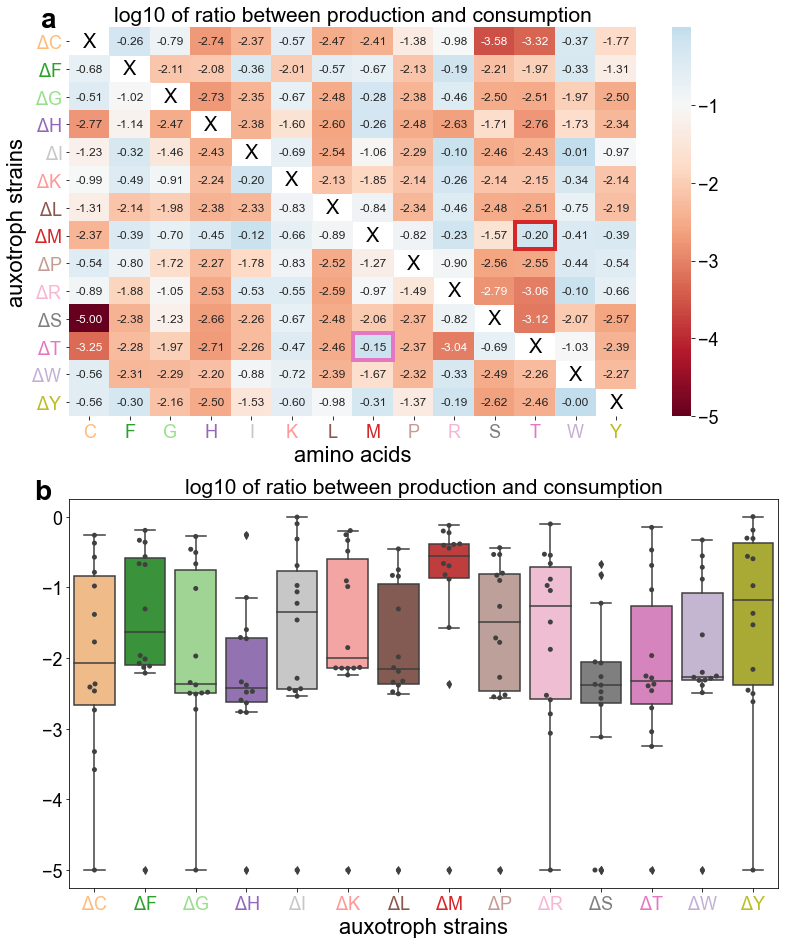

In [5]:
fig_dims = figure_size_setting(1000)
fig_dims = [fig_dims[0], fig_dims[0]*1.2]
fig, axes = plt.subplots(2, 1, figsize=fig_dims)

ax = axes[0]
production_stoichiometry_ratio = production_ratio_array / stoichiometry_array
production_stoichiometry_ratio[production_stoichiometry_ratio<=0] = 1
sort_order = np.argsort(np.min(production_stoichiometry_ratio,1))[::-1]
mask = np.eye(production_ratio_array.shape[0], dtype=bool)
g = sns.heatmap(np.log10((production_ratio_array / stoichiometry_array) + 1e-5), mask=mask, center=-1, annot=True, fmt='.2f', ax=ax, cmap = "RdBu")
#### highlight cells
from matplotlib.patches import Rectangle
w, h = 1, 1
x = 7; y = 11; ax.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor=color_selected[y], lw=4, clip_on=False))
x = 11; y = 7; ax.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor=color_selected[y], lw=4, clip_on=False))
for i in range(production_ratio_array.shape[0]):
    ax.text(i+0.5, i+0.5, 'X', fontsize=20, ha='center', va='center', color='black')
ax.set_xlabel('amino acids')
ax.set_ylabel('auxotroph strains')
ax.set_xticks(np.array(range(production_ratio_array.shape[1]))+0.5)
ax.set_xticklabels(list(map(lambda x: x, list(df_amino_acid_ID.index))))
ax.set_yticks(np.array(range(production_ratio_array.shape[0]))+0.5)
ax.set_yticklabels(df_amino_acid_ID.index)
for ticklabel, tickcolor in zip(g.get_yticklabels(), color_selected):
    ticklabel.set_color(tickcolor)
for ticklabel, tickcolor in zip(g.get_xticklabels(), color_selected):
    ticklabel.set_color(tickcolor)
ax.set_yticklabels(list(map(lambda x: r"$\Delta$"+x, list(df_amino_acid_ID.index))))
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
ax.set_title('log10 of ratio between production and consumption', fontsize=21)
ax.text(-0.05, 1.0, "a", transform=ax.transAxes, fontsize=28, fontweight='bold')

ax = axes[1]
ratio_array = (production_ratio_array / stoichiometry_array)[np.ix_(sort_order, sort_order)]
ratio_array = np.log10(ratio_array + 1e-5)
df_ratio = pd.DataFrame(ratio_array, columns = df_amino_acid_ID.index[sort_order])
df_ratio.index = df_amino_acid_ID.index[sort_order]
df_ratio.index.name = 'auxotroph strains'
df_ratio = df_ratio.reset_index().melt(id_vars='auxotroph strains')

strain_order = df_amino_acid_ID.index
g2 = sns.boxplot(x='auxotroph strains', y='value', data=df_ratio, order=strain_order, palette=color_selected)
g2 = sns.swarmplot(x='auxotroph strains', y='value', data=df_ratio, color=".25", order=strain_order)
ax.set_title('log10 of ratio between production and consumption', fontsize=21)
ax.set_ylabel('')
ax.set_xticks(np.array(range(production_ratio_array.shape[1])))
ax.set_xticklabels(list(map(lambda x: r"$\Delta$"+x, list(df_amino_acid_ID.index))))
for ticklabel, tickcolor in zip(g2.get_xticklabels(), color_selected):
    ticklabel.set_color(tickcolor)
ax.text(-0.05, 1.0, "b", transform=ax.transAxes, fontsize=28, fontweight='bold')

fig.tight_layout()
#fig.savefig('./figures/SI figures/SI_Fig_6.pdf', dpi=300)
